<h1><center>TP3 Opinion Mining</center></h1>

Élaboré par : **Iheb Jridi**

# Problematic

The **Gilets Jaunes** movement is a social mobilization that appeared in mid-November 2018 in France, and has spread to neighboring countries like Belgium.

In fact, since the price of fuel in France has not increased since the 1960s, the government gave orders in early November to apply a 23% increase for the price of diesel and 15% for the price gasoline and also scheduled another 11.5% increase for both fuels from January 2019.

This increase will cost vehicle users between 200 and 550 € in 2022. However, this increase was *only* the last straw that made the tide overflow: the standard of living of the French is in continuous fall and some territories are neglected by governments.

Multiple causes then led to the triggering of this movement which began in the first place on social networks, in particular **Twitter**. The hashtag **#GiletsJaune** et cie have been at the top of Twitter trends for over a month.

It is therefore important to analyze the tweets published on this subject, to interpret them and to classify them into positive and negative tweets.

In [1]:
from IPython.display import HTML,display 
display(HTML("<center><img src='https://upload.wikimedia.org/wikipedia/commons/0/0a/%C3%89valuationCh%C3%B4mageFranceAo%C3%BBt2017.png'></center"))

# Solution Presentation

In this perspective, **opinion mining** in general and **sentiment analysis** in particular, constitute a rich toolbox which makes it possible to analyze in a considerably easier way the web content released by social network in order to draw interpretations and / or classify it.

In [2]:
import numpy as np
import pandas as pd
import wordcloud as wc
from nltk.tokenize import word_tokenize
import warnings
import re
warnings.filterwarnings("ignore")

# Data Preparation

The first problem encountered was the data file format. We then opted for manual reading without the *Pandas* library.

In [62]:
data = pd.DataFrame(columns=['Tweet','Sentiment'])

In [63]:
f = open('giletjaune.csv', "r",encoding="latin1")
lines = f.readlines()
print(len(lines))
index = 1
for line in lines:
    if(index != 1): ## ignore the header
        T = line.split(",")
        sentiment = T[len(T)-1][:-2]
        m = re.search('""(.+?)""', line)
        if(m):
            tweet = m.group(1)
            data = data.append({'Tweet': tweet,'Sentiment': sentiment}, ignore_index=True)
    index = index + 1

52


The classes mentioned in the file are sometimes incorrect. The code below solves this problem. This step is essential before the execution of the classification algorithm.

In [64]:
data = data.loc[data["Sentiment"] != "Neutral",:]
data = data.loc[data["Sentiment"] != "Neutra",:]
data.Sentiment = data.Sentiment.replace(value = "Positive",regex="P.*")
data.Sentiment = data.Sentiment.replace(value = "Negative",regex="N.*")


# WordCloud
A wordcloud (or word cloud) makes it possible to identify the most frequent words in a textual flow in order to draw the thematic.

## Tweets classification and tokenization
The two variables **TokenizedNegativeTweets** and **TokenizedPositiveTweets** contain negative and positive tweets respectively as a string.

In [67]:
NegativeTweets,PositiveTweets = data.loc[data["Sentiment"] == "Negative","Tweet"],data.loc[data["Sentiment"] == "Positive","Tweet"]
TokenizedNegativeTweets = ""
TokenizedPositiveTweets = ""
for t in NegativeTweets:
    TokenizedNegativeTweets = TokenizedNegativeTweets+" "+t
for t in PositiveTweets:
    TokenizedPositiveTweets = TokenizedPositiveTweets+" "+t

In [68]:
NegativeTweets

1    @RusoAzul It was more like a contract between ...
2    @DoctorKropotkin @BethLynch2020 @VryKranky Mis...
3    Also the antifas on this video trying to hack ...
4    RT @Unjum_Mirza: #Metro this morning: #France ...
5    When Macron disembarked from his jet, rather t...
7                         RT @Sligogirls: #giletjaune 
Name: Tweet, dtype: object

## Import of non-meaningful English words

Les stopwords tel que les articulateurs logiques doivent être supprimés de flux textuel puisque ces derniers peuvent pousser au fait que des termes importants n'apparaissent pas dans le nuage des mots.
En addition, nous devons ajouter les termes reliés au mouvement en question.

In [69]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words("english"))
stop_words = stop_words+["YellowVest","Vest","GiletJaune","GiletsJaune",
                         "GiletsJaunes","https","RT","Paris","France",
                         "co","Yellow Vest","Yellow"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Negative Tweets WordCloud

Les mots les plus fréquents dans les tweets négatifs sont *Police, Battle (bataille) et Triomphe* (ce site était vandalisé pendant le mouvement).
Aussi, on peut interpréter que l'utilisateur *Antibullshit12* est un influenceur

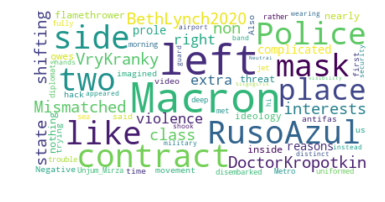

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
TokenizedNegativeTweets = str(TokenizedNegativeTweets)
wordcloud_neg = wc.WordCloud(max_font_size=50, max_words=100, background_color="white",stopwords = stop_words).generate(TokenizedNegativeTweets)
plt.figure()
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

## Positive Tweets WordCloud

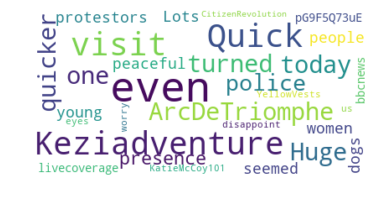

In [72]:
TokenizedPositiveTweets = str(TokenizedPositiveTweets)
wordcloud_pos = wc.WordCloud(max_font_size=50, max_words=100, background_color="white",stopwords = stop_words).generate(TokenizedPositiveTweets)
plt.figure()
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

# Classification using Naive Bayes Classifier of NLTK

## Train - Validation split

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["Tweet"], data['Sentiment'], test_size=0.3, random_state = 42,stratify=data['Sentiment'])

## Feature Extraction -  BagOfWords

The NaiveBayesClassifier model from the NLTK library takes as input a *Bag Of Words:* it is a data structure where each line represents a flow element and each column is a word. A value of **True** in a [i, j] box indicates that the tweet i contains the word j.

In [88]:
train = list(zip(X_train,y_train))

In [89]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
all_words = set(stemmer.stem(word.lower()) for passage in train for word in word_tokenize(passage[0]))
t = [({word: (word in word_tokenize(x[0])) for word in all_words if not word in set(stopwords.words('english'))}, x[1]) for x in train]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Training

In [90]:
from nltk import NaiveBayesClassifier
classifierNB = NaiveBayesClassifier.train(t)

## Test and Validation

In [91]:
predicted = []
tokenized_test_data = []
for i in X_test:
    test_sent_features = {word.lower(): (word in word_tokenize(i.lower())) for word in all_words}
    tokenized_test_data.append(test_sent_features)
    predicted.append(classifierNB.classify(test_sent_features))

In [92]:
from sklearn.metrics import confusion_matrix
pd.crosstab(np.array(y_test), np.array(predicted), 
            rownames=['Actual'], 
            colnames=['Predicted'])

Predicted,Negative
Actual,
Negative,2
Positive,1


## Classification using other algorithms

In this part, we will proceed to classification using two other models. We opted for logistic regression and Support Vector Machine. These two algorithms show great reliability according to the classification of textual content.

## Data Prep

Unlike the Naive Bayes model, these two models take a corpus as input. This corpus can be built using the label encoder tool.

In [93]:
corpus = []
for i in data["Tweet"]:
    review = re.sub('[^a-zA-Z]', ' ', i)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)
    
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = data.iloc[:, 1].values

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, le.fit_transform(y), test_size = 0.5, random_state = 0)

## Classification

In [98]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
lr = LogisticRegression()
svm = SVC(kernel="rbf",probability=True)

Classifiers = pd.DataFrame(data={'ClassifierName': ["Logistic Regression","SVM"] ,'Classifier': [lr,svm]})
                                                    
accuracy=[]
accuracies=[]
for index, row in Classifiers.iterrows():
    MyModel = row['Classifier'] # select the model
    MyModel.fit(X_train1,y_train1) # train the model
    y_pred=MyModel.predict(X_test1) # predict the test data
    accuracy.append(metrics.accuracy_score(y_test1, y_pred))
    
Classifiers["Accuracy"]=accuracy
Classifiers

,ClassifierName,Classifier,Accuracy
0,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",0.75
1,SVM,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.75


# Wep Scraping

In [ ]:
import tweepy
import csv 
api_key = 'your_api_key'
api_secret = 'your_api_secret' 
access_token = 'your_access_token'
access_token_secret = 'your_acces_token_secret'
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

csvFile = open('scraped_tweets.csv', 'a')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,q="#giletsjaunes",
                           lang="en").items(1):
    csvWriter.writerow([[tweet.text]])

for tweet in tweepy.Cursor(api.search,q="#GiletsJaunes",
                           lang="en").items(1):
    csvWriter.writerow([[tweet.text]])
    
for tweet in tweepy.Cursor(api.search,q="#YellowVest",
                           lang="en").items(1):
    csvWriter.writerow([[tweet.text]])
    
for tweet in tweepy.Cursor(api.search,q="#yellowvest",
                           lang="en").items(1):
    csvWriter.writerow([[tweet.text]])